# Imports

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import *
from keras.callbacks import *
from keras.models import *
from keras.losses import *
from keras.optimizers import *
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt
import seaborn as sns
import glob

Using TensorFlow backend.


# Data

In [2]:
train_df = pd.read_csv('./data/sign_mnist/sign_mnist_train.csv')
test_df = pd.read_csv('./data/sign_mnist/sign_mnist_test.csv')
X = train_df.drop(['label'], axis=1).values.reshape(-1, 28,28) / 255
y = train_df['label'].values

#X_test = test_df.drop(['label'], axis=1).values.reshape(-1, 28,28) / 255

# Generator

In [3]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = Embedding(input_dim=24, output_dim=24)(label_input)
x = Reshape((24,))(x)
x = concatenate([x, latent_input], axis=-1)
x = Dense(7*7*128)(x)
x = LeakyReLU()(x)
x = Reshape((7,7,128))(x)
x = UpSampling2D()(x)
x = Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = UpSampling2D()(x)
x = Conv2D(32, kernel_size=3, strides=1, padding='same')(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Conv2D(1, kernel_size=3, strides=1, padding='same')(x)
x = Activation('sigmoid')(x)
x = Reshape((28,28,))(x)
generator = Model(inputs=[latent_input, label_input], outputs=x)
generator.summary()

W0731 14:43:26.951677 139957862037312 deprecation_wrapper.py:119] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0731 14:43:26.973946 139957862037312 deprecation_wrapper.py:119] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0731 14:43:26.974917 139957862037312 deprecation_wrapper.py:119] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0731 14:43:27.026104 139957862037312 deprecation_wrapper.py:119] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_nei

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 24)        576         label_input[0][0]                
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 24)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
concatenat

# Discriminator

In [4]:
discriminator = Sequential()
discriminator.add(Reshape((28,28,1),input_shape=(28,28)))
discriminator.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2,2)))
discriminator.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2,2)))
discriminator.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'))
discriminator.add(MaxPooling2D(pool_size=(2,2)))    
discriminator.add(Flatten())
discriminator.add(Dense(128, activation='relu'))
discriminator.add(Dense(25, activation='softmax'))
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.summary()

W0731 14:43:28.021440 139957862037312 deprecation_wrapper.py:119] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0731 14:43:28.090120 139957862037312 deprecation_wrapper.py:119] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
__________

# GAN

In [5]:
latent_input = Input(shape=(100,), name='latent_input')
label_input = Input(shape=(1,), name='label_input')
x = generator([latent_input, label_input])
x = discriminator(x)
gan = Model(inputs=[latent_input, label_input], outputs=x)
discriminator.trainable = False
gan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
latent_input (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
label_input (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28)       877505      latent_input[0][0]               
                                                                 label_input[0][0]                
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 25)           132825      model_1[1][0]                    
Total para

In [6]:
discriminator.trainable = True
discriminator.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.001))
discriminator.trainable = False
gan.compile(loss='sparse_categorical_crossentropy', metrics=['acc'], optimizer=Adam(0.0003))

In [12]:
def random_mnist_set(X, y, size=10):
    length = len(X)
    indices = np.random.choice(length, size)
    return X[indices], y[indices]

def random_generated_set(generator, size=10):
    latents = np.random.normal(0, 1, (size, 100))
    return generator.predict_on_batch({'latent_input':latents,
                      'label_input':np.random.randint(24, size=size)})

In [13]:
save_interval = 500
epochs = save_interval*10+1
batch_size=20
history = {'dloss':[], 'gloss':[]}
for iteration in range(epochs):
    discriminator.trainable=True
    X_sample, y_sample = random_mnist_set(X, y, batch_size)
    dloss_real = discriminator.train_on_batch(X_sample, y_sample)
    dloss_fake = discriminator.train_on_batch(random_generated_set(generator, size=batch_size), np.full(batch_size, 10))
    
    discriminator.trainable=False
    
    gan_labels = np.random.randint(10, size=batch_size)
    gloss = gan.train_on_batch({'latent_input':np.random.normal(0, 1, (batch_size, 100)),
                        'label_input':gan_labels}, 
                       gan_labels)
    
    history['dloss'].append((dloss_real[0]+dloss_fake[0])/2)
    history['gloss'].append(gloss[0])
    if iteration % save_interval == 0:
        print('generator: loss={}. acc={}'.format(gloss[0], gloss[1]))
        print('discriminator: loss_real={}, acc_real={}'.format(dloss_real[0],dloss_real[1]))
        print('    loss_fake={}, acc_fake={}'.format(dloss_fake[0],dloss_fake[1]))
        generator.save_weights('./models/sign_mnist/generator_sign_mnist_{0:05d}.h5'.format(iteration))

W0731 14:45:23.340470 139957862037312 deprecation.py:323] From /home/abel/anaconda3/envs/projects/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


generator: loss=3.188460111618042. acc=0.0
discriminator: loss_real=3.2264373302459717, acc_real=0.0
    loss_fake=3.26692533493042, acc_fake=0.0
generator: loss=4.2371134757995605. acc=0.0
discriminator: loss_real=1.726352334022522, acc_real=0.30000001192092896
    loss_fake=0.33780303597450256, acc_fake=1.0
generator: loss=2.1151504516601562. acc=0.44999998807907104
discriminator: loss_real=0.9375909566879272, acc_real=0.8500000238418579
    loss_fake=0.24668189883232117, acc_fake=0.949999988079071
generator: loss=3.980525255203247. acc=0.0
discriminator: loss_real=0.7561786770820618, acc_real=0.75
    loss_fake=0.0658765509724617, acc_fake=1.0
generator: loss=3.6708381175994873. acc=0.0
discriminator: loss_real=0.3064199984073639, acc_real=0.8999999761581421
    loss_fake=0.06837905943393707, acc_fake=1.0
generator: loss=2.106133460998535. acc=0.0
discriminator: loss_real=0.20397722721099854, acc_real=0.8999999761581421
    loss_fake=0.15990032255649567, acc_fake=0.949999988079071
g

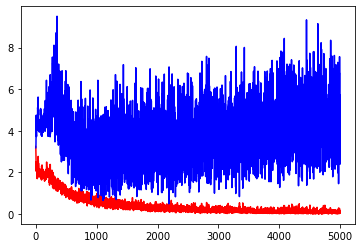

In [14]:
plt.plot(history['dloss'], 'r')
plt.plot(history['gloss'], 'b')

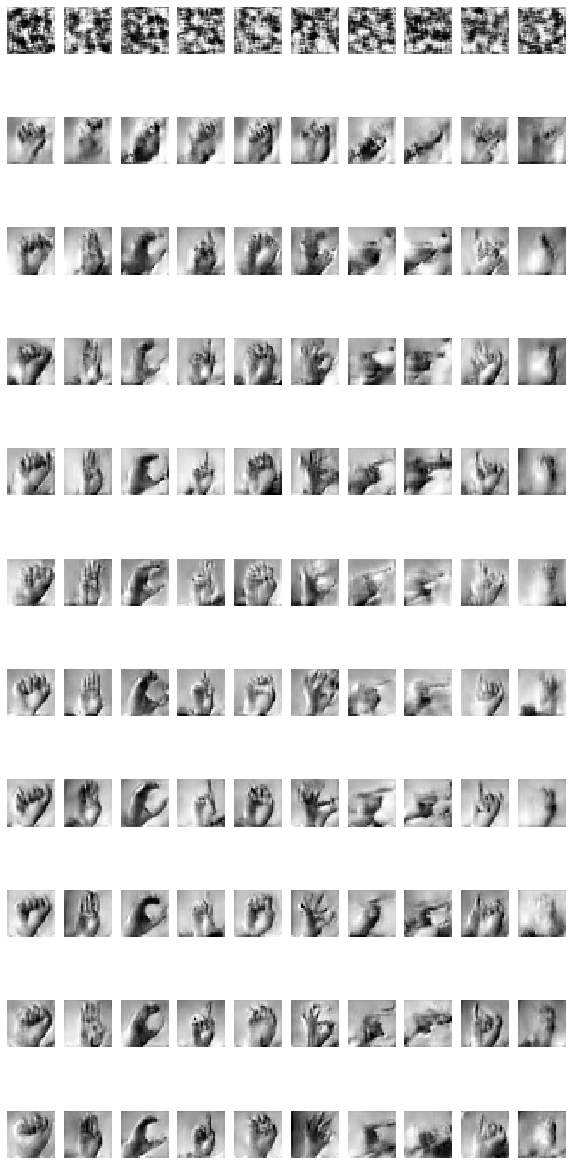

In [15]:
checkpoints = sorted(glob.glob('./models/sign_mnist/generator_sign_mnist_*.h5'))

plt.figure(figsize=(10,2*len(checkpoints)))
for i,cp in enumerate(checkpoints):
    generator.load_weights(cp)
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')

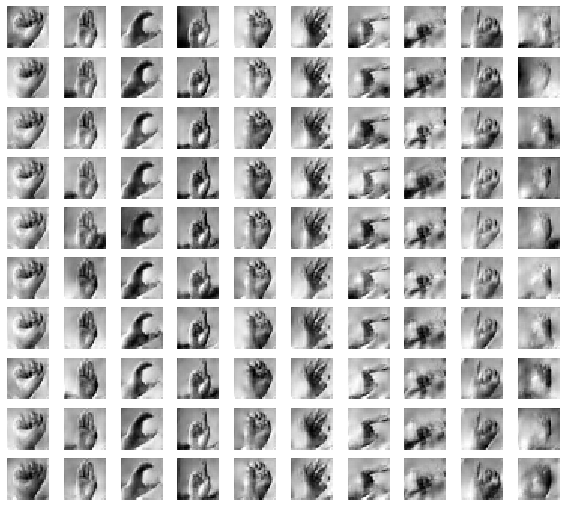

In [16]:
generator.load_weights(checkpoints[-1])
plt.figure(figsize=(10,10))
for i in range(10):
    generated = generator.predict_on_batch({'latent_input':np.random.normal(0, 1, (10, 100)),
                      'label_input':np.arange(10)})
    for j, g in enumerate(generated):
        plt.subplot(len(checkpoints),10,10*i+j+1)
        plt.imshow(g, cmap='gray')
        plt.axis('off')